# Comparison of Cloud Top SLF values from NorESM2 and CALIOP
Just like parameterspace.ipynb

In [1]:
import sys

# Add last directory to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis")
# Add common resources
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

from classes import CT_SLF_Metric

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    op_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(op_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_slfs/'
output_dir = 'figures/'
case_dir = 'mnth15runs/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(case_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [3]:
#all_cases = os.listdir('/home/jonahks/drivemount/mnth15runs/')
all_cases = os.listdir(case_dir)

all_cases

['20200112_002538_singleparam_nudge_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_10_inp_1',
 '20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 'error_vs_iso.png',
 '.ipynb_checkpoints',
 'unused',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 'runs_as_vectors.png',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20200109_1541_wbf_1.0_inp_1.0',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
 'paramspace.png',
 '20191122_161009_sampleparamset_wbf_1_inp_1']

In [4]:
base_case = '20200109_1541_wbf_1.0_inp_1.0'
cases = ['20200109_1541_wbf_1.0_inp_1.0', 
         '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
         '20200112_002538_singleparam_nudge_wbf_1_inp_0',
         '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
         '20200116_130416_nudged_wbfmods_wbf_10_inp_1']

In [20]:
test = CT_SLF_Metric(case_dir)

for i in cases:
    test.add_case(i)
test.set_origin(base_case)

mnth15runs/20200109_1541_wbf_1.0_inp_1.0/20200109_1541_wbf_1.0_inp_1.0_slfvars.nc
mnth15runs/20200110_142006_singleparam_nudge_wbf_1_inp_1000/20200110_142006_singleparam_nudge_wbf_1_inp_1000_slfvars.nc
mnth15runs/20200112_002538_singleparam_nudge_wbf_1_inp_0/20200112_002538_singleparam_nudge_wbf_1_inp_0_slfvars.nc
mnth15runs/20200116_130416_nudged_wbfmods_wbf_0.01_inp_1/20200116_130416_nudged_wbfmods_wbf_0.01_inp_1_slfvars.nc
mnth15runs/20200116_130416_nudged_wbfmods_wbf_10_inp_1/20200116_130416_nudged_wbfmods_wbf_10_inp_1_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


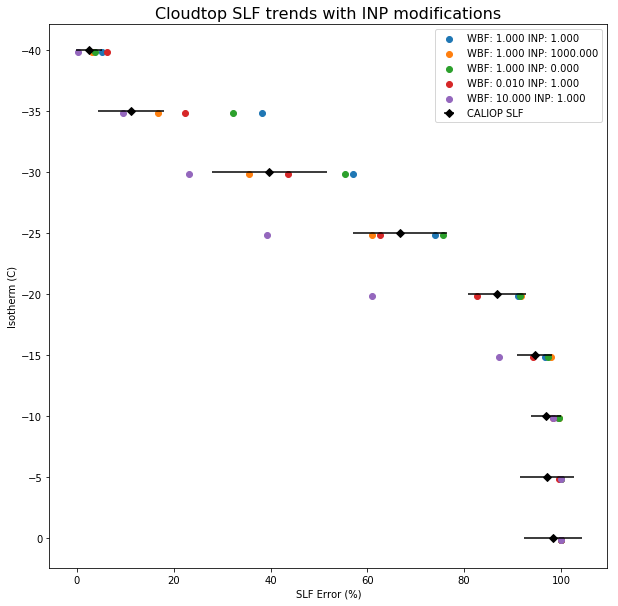

In [21]:
_temp = test.plot_isos_ct()

In [23]:
filename = '%s/inpmods_cloudtops_nudgedruns.png' % (output_dir)

_temp.savefig(filename,format = 'png', dpi = 200)
_temp.clf()

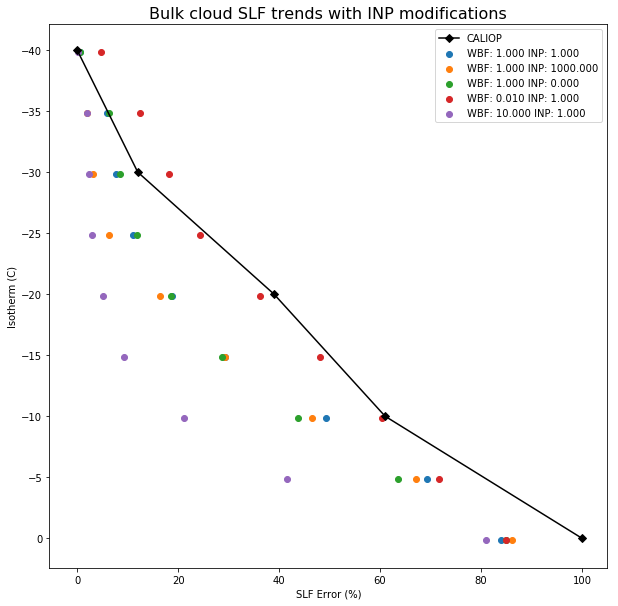

In [22]:
bulkcloud_inp = test.plot_isos_bulk()

In [24]:
filename = '%s/inpmods_bulkclouds_nudgedruns.png' % (output_dir)

bulkcloud_inp.savefig(filename,format = 'png', dpi = 200)
bulkcloud_inp.clf()

In [50]:
ds = test_df
# Select dates after a 3 month wind-up and average slf, unless it is a monthlong test run
if (len(ds['time']) > 1):
    try:
        ds['SLF_ISOTM'] = (ds['SLFXCLD_ISOTM'] / ds['CLD_ISOTM']).sel(time=slice('0001-04-01',
                            '0002-03-01'))
    except:
        ds['SLF_ISOTM'] = (ds['SLFXCLD_ISOTM'] / ds['CLD_ISOTM']).sel(time=slice('2000-04-01',
                            '2001-03-01'))
    ds['SLF_ISOTM_TAVG'] = ds['SLF_ISOTM']

In [19]:
filename

'figures//inpmods_nudgedruns.png'

In [25]:
ts = np.linspace(200,300, num = 100)
lams = 2.898e-3 / ts

Text(0,0.5,'Peak wavelength (um)')

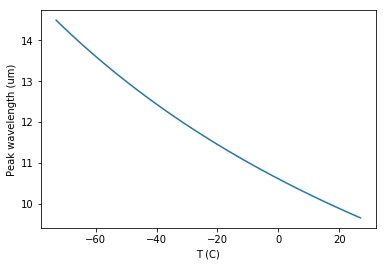

In [27]:
plt.plot(ts-273, lams*1e6)
plt.xlabel('T (C)'); plt.ylabel('Peak wavelength (um)')